In [1]:
import numpy as np
import sys
sys.path.append('/data/LLMs/LMMS/')
from transformers_encoder import TransformersEncoder
from transformers import RobertaModel, RobertaTokenizer
from vectorspace import SensesVSM
import spacy
en_nlp = spacy.load('en_core_web_trf')  # required for lemmatization and POS-tagging 
en_nlp_lg = spacy.load('en_core_web_lg')  # required for lemmatization and POS-tagging 
import torch
from wn_utils import WN_Utils
wn_utils = WN_Utils()  # WordNet auxilliary methods (just for describing results)
basePath = '/data/LLMs/LMMS/'

/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# NLM/LMMS paths and parameters
vecs_path = f'{basePath}data/vectors/lmms-sp-wsd.roberta-large.vectors.txt'
wsd_encoder_cfg = {
    'model_name_or_path': 'roberta-large',
    'min_seq_len': 0,
    'max_seq_len': 512,
    'layers': [-n for n in range(1, 24 + 1)],  # all layers, with reversed indices
    'layer_op': 'ws',
    'weights_path': f'{basePath}data/weights/lmms-sp-wsd.roberta-large.weights.txt',
    'subword_op': 'mean'
}

In [3]:
model_str = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_str)
model = RobertaModel.from_pretrained(model_str)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print('Loading NLM and sense embeddings ...')  # (takes a while)
wsd_encoder = TransformersEncoder(wsd_encoder_cfg)
senses_vsm = SensesVSM(vecs_path, normalize=True)
print('Done')

Loading NLM and sense embeddings ...


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done


In [4]:
def modify_join_tokens(lemma, next_lemma, pos, skip_words):
    
    # key is lemma to modify
    # value is a list with three components 
    # 1) updated lemma, 2) updated pos, 3) whether to skip upcoming words 
    join_tokens_dict = {'brand': ['brand-new', 'ADJ', ['-', 'new']], 'pedalling': ['pedal', 'VERB', []], 
                        'scissor': ['scissors', 'NOUN', []], 'stabbing': ['stab', 'VERB', []], 
                        'all': ['all-night', 'ADJ', ['-', 'nighter']], 'Scissor': ['scissors', 'NOUN', []], 
                        'Polar': ['Polar', 'ADJ', []], 'tailless': ['tailless', 'ADJ', []], 
                        'underwater': ['underwater', 'ADJ', []], 
                        'dairy': ['dairy', 'NOUN', []], 
                        'spacewalk': ['spacewalk', 'VERB', []], 
                        'underneath': ['underneath', 'ADV', []], 'U.S.A.': ['U.S.A.', 'NOUN', []], 
                        'seventh': ['seventh', 'ADJ', []], 
                        'higher': ['higher', 'ADJ', []], 'showcase': ['showcase', 'NOUN', []], 
                        'artisan': ['artisan', 'NOUN', []],  
                        'surrounding': ['surroundings', 'NOUN', []]}
    
    # these don't exist in LMMS
    if pos == 'PROPN' or pos == 'NUM':
        pos = 'NOUN'

    if lemma in join_tokens_dict.keys():
        lemma_new = join_tokens_dict[lemma][0]
        pos_new = join_tokens_dict[lemma][1]
        # in some cases, we want to join words together (like brand new -> brand-new)
        # in this case we need to skip the sense embedding for the words that follow (e.g. new)
        # so we add them to skip_words. However, we also need to check to make sure 
        # the upcoming words match, and if not, don't perform the update.
        remove_tokens = join_tokens_dict[lemma][2]
        if len(remove_tokens) != 0: 
            if next_lemma not in remove_tokens: # no match, don't perform an update
                return lemma, pos, skip_words     
        skip_words.extend(remove_tokens)
        return lemma_new, pos_new, skip_words
    else:
        return lemma, pos, skip_words

In [5]:
# words to merge with the next token(s)
merge_word = {'brand_new': 'brand-new', 'all_-': 'all-night', 'united_states': \
                'united_states', 'ear_piercings': 'earring', 'tear_gas': 'tear_gas'}

# how many tokens to skip after merging words 
num_skip = {'brand-new': 1, 'all-night': 2, 'united_states': 1, 'earring': 1, 'tear_gas': 1}

def modify_pos_word(word, pos, next_word, merge_word=merge_word, num_skip=num_skip):
    
    # words to modify 
    update_words = {'artisanal': 'artisan', 'lawnmower': 'mower', 'fulltime': 'full-time', 
                    'waterbed': 'water_bed', 'airbed': 'air_mattress', 'videogame': 'video_game', '1970': 'seventies', 
                    'micromanager': 'manager', 'showcase': 'show_off', 'scissor': 'scissors', 'vikings': 'viking', 
                    'wildland': 'land', 'landform': 'terrain', 'stabbing': 'stab', 'shorter': 'short', 
                    'pedalling': 'pedal', 'freezing': 'frigid', 'tong': 'tongs', 'feet': 'ft'}
    
    # words to modify pos tagging 
    pos_tag = {'mild': 'ADJ', 'spacewalk': 'VERB', 'underwater': 'ADJ', 'artisan': 'NOUN', 
               'surrounding': 'ADJ', 'brand-new': 'ADJ', 'all-night': 'ADJ', 'underneath': 'ADV', 'polar': 'ADJ', 
               'stab': 'VERB', 'tear_gas': 'NOUN', 'dairy': 'NOUN', 'seventh': 'ADJ', 'tailless': 'ADJ'}
    
    modified = False
    
    # for words that are combined with their next token
    if f'{word}_{next_word}' in merge_word.keys():
        print(f"Merging: {word}_{next_word}")
        word = merge_word[f'{word}_{next_word}']
        modified = True
        
    # words we updated
    if word in update_words.keys():
        word = update_words[word]
        modified = True
    
    # get updated pos tag based on the (potentially) modified representation
    if word in pos_tag.keys():
        pos = pos_tag[word]
        
    # for merged or updated words, check if we should skip the next token(s)
    if word in num_skip.keys() and modified:
        skip_next = num_skip[word]
    else:
        skip_next = 0

   
    return word, pos, skip_next
        
        
def split_words_and_combine(word_list):
    
    split_word_dict = {'wildland': 'wild land', 
                       'landform': 'land form'}
    word_list_new = []
    for w in word_list:
        if w in split_word_dict.keys():
            print(w)
            word_list_new.extend(split_word_dict[w].split())
        else:
            word_list_new.append(w)
    
    sentence = ' '.join(word_list_new)
    sentence += '.'
    return sentence

def merge_tokens(tokens, merge_words=merge_word, num_skip_dict=num_skip):

    new_tokens = []
    num_skip = 0
    for idx, t in enumerate(tokens):
        
        if num_skip > 0:
            num_skip -= 1
            continue
        try:
            next_token = tokens[idx+1]
        except:
            next_token = 'none'

        if f'{t.lower()}_{next_token.lower()}' in merge_words.keys():
            modified_word = merge_words[f'{t.lower()}_{next_token.lower()}']
            print("MODIFYING FOR ROBERTA: ", modified_word)
            num_skip = num_skip_dict[modified_word]
            contextual_token = ''
            for i in range(num_skip+1):
                contextual_token += tokens[idx+i]
            new_tokens.append(contextual_token)
        else:
            new_tokens.append(t)

    return new_tokens

In [ ]:
# load pereria text
pereira_path = "/home3/ebrahim/what-is-brainscore/pereira_data/sentences_ordered_dereferenced.txt"
with open(pereira_path, "r") as file:
    # Read the contents line by line into a list
    pereira_text = [line.strip() for line in file]
    
no_sense_words = []
no_sense_sentences = []
end_for_loop = False
lemma_arr = []
postag_arr = []
skip_next = False
for j, sentence in enumerate(pereira_text):
    
    doc = en_nlp(str(sentence))
    tokens = [t.text for t in doc]
    skip_words = []
    if j % 100 == 0:
        print(j)
    skip_next = 0
    
    merged_tokens = merge_tokens(tokens)

    # retrieve contextual embeddings  
    #ctx_embeddings = wsd_encoder.token_embeddings([tokens])[0]
    
    for i, d in enumerate(doc):
        
        if skip_next > 0:
            print("Skipping: ", d)
            skip_next = skip_next - 1
            continue
        
        if d.pos_ == 'PUNCT':
            continue
        
        pos = d.pos_
        
        try:
            next_tok =  str(d.nbor())
        except:
            next_tok = 'NONE'
            
        word, pos, skip_next = modify_pos_word(d.lemma_.lower(), pos, next_tok.lower())
        
         # these don't exist in LMMS
        if pos == 'PROPN' or pos == 'NUM':
            pos = 'NOUN'
            
        
        # don't add if it's a stop word and it was not changed
        if d.is_stop and word == d.lemma_:
            continue
            
        #lemma, pos, skip_words = modify_join_tokens(d.lemma_, next_lemma, d.pos_, skip_words)
        lemma_arr.append(word)
        postag_arr.append(pos)

    
    

In [10]:
# dictionary where key is word_pos, and value is number of senses
num_senses = senses_vsm.num_senses_fast(lemma_arr=lemma_arr, postag_arr=postag_arr)  

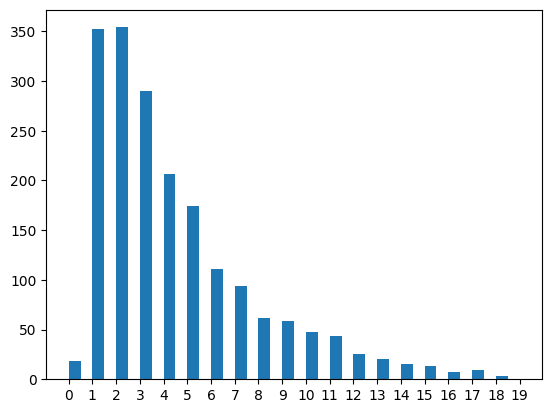

In [17]:
from matplotlib import pyplot as plt
plt.hist(list(num_senses.values()), bins=np.arange(0,20,1), width=0.5)
plt.xticks(np.arange(0,20))
plt.show()

In [11]:
# load pereria text
fed_path = "/home3/ebrahim/what-is-brainscore/federonko_data/sentences_ordered.txt"
with open(fed_path, "r") as file:
    # Read the contents line by line into a list
    sentence_text = [line.strip() for line in file]
    
no_sense_words = []
no_sense_sentences = []
end_for_loop = False
lemma_arr = []
postag_arr = []
skip_next = False
for j, sentence in enumerate(sentence_text):
    
    doc = en_nlp(str(sentence))
    tokens = [t.text for t in doc]
    skip_words = []
    if j % 100 == 0:
        print(j)
    skip_next = 0
    
    for i, d in enumerate(doc):
        
        
        if d.pos_ == 'PUNCT':
            continue
        
        pos = d.pos_
        
        word = d.lemma_.lower()
        
        if word == 'clothe':
            word = d.text
            
        
         # these don't exist in LMMS
        if pos == 'PROPN' or pos == 'NUM':
            pos = 'NOUN'
            
        
        # don't add if it's a stop word and it was not changed
        if d.is_stop and word == d.lemma_:
            continue
            
        #lemma, pos, skip_words = modify_join_tokens(d.lemma_, next_lemma, d.pos_, skip_words)
        lemma_arr.append(word)
        postag_arr.append(pos)

# dictionary where key is word_pos, and value is number of senses
num_senses = senses_vsm.num_senses_fast(lemma_arr=lemma_arr, postag_arr=postag_arr)      
    

0


In [14]:
senses_vsm.word_pos_sk['Alex']

defaultdict(list, {})

In [13]:
zero_senses = [key for key, val in num_senses.items() if val==0]
zero_senses

['alex_NOUN',
 'amy_NOUN',
 'ann_NOUN',
 'charlie_NOUN',
 'emma_NOUN',
 'eva_NOUN',
 'timmy_NOUN',
 'jessie_NOUN',
 'near_ADP',
 'jill_NOUN',
 'liz_NOUN',
 'larry_NOUN',
 'i_PRON',
 'steve_NOUN',
 'susan_NOUN',
 'outside_ADP',
 'hannah_NOUN',
 'brand_ADJ']